First let's import pandas and numpy libraries to handle spreadsheets and dataframes, matplotlib to display basic plots and Prophet for predictions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import fbprophet as Prophet


/Users/omi/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/omi/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Read in the main spreadsheet that we are going to use. This contains ~20years worth of real estate data for many US states. We only be using a small sample of this data for this tuorial.

In [2]:
state_time_series = pd.read_csv('State_time_series.csv')
# Make sure the date is interpreted correctly.
state_time_series.Date = pd.to_datetime(state_time_series.Date)
# Add another column just for year 
state_time_series['year']= state_time_series.Date.dt.year

# Display the final few rows
# to get an idea about how our dataset looks like
state_time_series.tail()


,Date,RegionName,DaysOnZillow_AllHomes,HomesSoldAsForeclosuresRatio_AllHomes,InventorySeasonallyAdjusted_AllHomes,InventoryRaw_AllHomes,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,...,ZHVI_CondoCoop,ZHVI_MiddleTier,ZHVI_SingleFamilyResidence,ZHVI_TopTier,ZRI_AllHomes,ZRI_AllHomesPlusMultifamily,ZriPerSqft_AllHomes,Zri_MultiFamilyResidenceRental,Zri_SingleFamilyResidenceRental,year
13021,2017-08-31,Virginia,NaN,2.6026,39217.0,42952.0,255.959227,150.000000,145.424242,147.681443,...,291200.0,245900.0,236500.0,492100.0,1527.0,1493.0,0.938,1717.0,1431.0,2017
13022,2017-08-31,Washington,NaN,2.0805,17986.0,23254.0,294.290861,216.225207,192.307692,182.703424,...,326500.0,342000.0,343700.0,643100.0,1801.0,1765.0,1.116,1669.0,1784.0,2017
13023,2017-08-31,WestVirginia,NaN,0.3122,9680.0,10468.0,107.870370,80.304061,91.092999,93.516101,...,113000.0,99800.0,99700.0,169700.0,874.0,874.0,0.672,870.0,874.0,2017
13024,2017-08-31,Wisconsin,NaN,0.9433,28198.0,32809.0,139.960992,123.377384,122.988506,114.902206,...,158900.0,167300.0,168200.0,277700.0,1180.0,1151.0,0.918,1062.0,1161.0,2017
13025,2017-08-31,Wyoming,NaN,NaN,4690.0,5239.0,171.496617,149.791667,135.649671,147.134084,...,189300.0,195400.0,195300.0,307800.0,1181.0,1145.0,0.916,1046.0,1153.0,2017


Let's sure that we are operating on valid data by getting all the states whose Zillow housing value index and median sold price columns are not null.

Then prepare a new spreadsheet with just these valid states in them.

In [3]:
states = set(state_time_series[~state_time_series['ZHVI_AllHomes'].isnull() & ~state_time_series['MedianSoldPrice_AllHomes'].isnull()]['RegionName'].values)

state_time_series_valid = state_time_series[state_time_series['RegionName'].isin(states)].copy()

state_time_series_valid.tail()

,Date,RegionName,DaysOnZillow_AllHomes,HomesSoldAsForeclosuresRatio_AllHomes,InventorySeasonallyAdjusted_AllHomes,InventoryRaw_AllHomes,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,...,ZHVI_CondoCoop,ZHVI_MiddleTier,ZHVI_SingleFamilyResidence,ZHVI_TopTier,ZRI_AllHomes,ZRI_AllHomesPlusMultifamily,ZriPerSqft_AllHomes,Zri_MultiFamilyResidenceRental,Zri_SingleFamilyResidenceRental,year
13015,2017-08-31,SouthCarolina,NaN,1.0227,29134.0,30506.0,178.027805,127.205598,112.841016,111.984925,...,141600.0,145000.0,145600.0,287000.0,1205.0,1194.0,0.798,1178.0,1196.0,2017
13021,2017-08-31,Virginia,NaN,2.6026,39217.0,42952.0,255.959227,150.000000,145.424242,147.681443,...,291200.0,245900.0,236500.0,492100.0,1527.0,1493.0,0.938,1717.0,1431.0,2017
13022,2017-08-31,Washington,NaN,2.0805,17986.0,23254.0,294.290861,216.225207,192.307692,182.703424,...,326500.0,342000.0,343700.0,643100.0,1801.0,1765.0,1.116,1669.0,1784.0,2017
13023,2017-08-31,WestVirginia,NaN,0.3122,9680.0,10468.0,107.870370,80.304061,91.092999,93.516101,...,113000.0,99800.0,99700.0,169700.0,874.0,874.0,0.672,870.0,874.0,2017
13024,2017-08-31,Wisconsin,NaN,0.9433,28198.0,32809.0,139.960992,123.377384,122.988506,114.902206,...,158900.0,167300.0,168200.0,277700.0,1180.0,1151.0,0.918,1062.0,1161.0,2017


Get top and bottom 5 costly states

In [4]:
costliest_states = state_time_series_valid[['RegionName', 'ZHVI_AllHomes']].groupby('RegionName').max().sort_values(by=['ZHVI_AllHomes'], ascending=False)[:5].index.values.tolist()
print(costliest_states)
cheapest_states = state_time_series_valid[['RegionName', 'ZHVI_AllHomes']].groupby('RegionName').max().sort_values(by=['ZHVI_AllHomes'], ascending=True)[:5].index.values.tolist()
print(cheapest_states)

['Hawaii', 'DistrictofColumbia', 'California', 'Massachusetts', 'NewJersey']
['WestVirginia', 'Oklahoma', 'Arkansas', 'Iowa', 'Ohio']


In [5]:
costliest_time_series = state_time_series_valid[state_time_series_valid.RegionName.isin(costliest_states)]
costliest_time_series.tail()


,Date,RegionName,DaysOnZillow_AllHomes,HomesSoldAsForeclosuresRatio_AllHomes,InventorySeasonallyAdjusted_AllHomes,InventoryRaw_AllHomes,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,...,ZHVI_CondoCoop,ZHVI_MiddleTier,ZHVI_SingleFamilyResidence,ZHVI_TopTier,ZRI_AllHomes,ZRI_AllHomesPlusMultifamily,ZriPerSqft_AllHomes,Zri_MultiFamilyResidenceRental,Zri_SingleFamilyResidenceRental,year
12979,2017-08-31,California,NaN,1.1441,58480.0,66168.0,434.615385,326.205288,276.332279,269.984944,...,465600.0,507700.0,516600.0,944000.0,2460.0,2448.0,1.592,2402.0,2465.0,2017
12983,2017-08-31,DistrictofColumbia,NaN,1.5138,1140.0,1123.0,567.013889,532.217262,425.101215,455.956947,...,533400.0,544600.0,601700.0,951800.0,2693.0,2654.0,2.294,2608.0,2751.0,2017
12986,2017-08-31,Hawaii,NaN,0.1285,6440.0,6673.0,596.975834,518.666667,453.746070,450.892128,...,426600.0,604800.0,720000.0,972200.0,2426.0,2405.0,1.962,2083.0,2536.0,2017
12996,2017-08-31,Massachusetts,NaN,5.9731,14964.0,17877.0,372.731645,249.888889,227.956683,225.000000,...,331900.0,378800.0,386000.0,657300.0,2201.0,2185.0,1.380,2093.0,2235.0,2017
13005,2017-08-31,NewJersey,NaN,4.1468,45880.0,50279.0,249.930556,172.508847,164.109848,172.668394,...,249500.0,308300.0,311600.0,550200.0,2066.0,2049.0,1.246,1836.0,2069.0,2017


In [6]:
cheapest_time_series = state_time_series_valid[state_time_series_valid.RegionName.isin(cheapest_states)]
cheapest_time_series.tail()


,Date,RegionName,DaysOnZillow_AllHomes,HomesSoldAsForeclosuresRatio_AllHomes,InventorySeasonallyAdjusted_AllHomes,InventoryRaw_AllHomes,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,...,ZHVI_CondoCoop,ZHVI_MiddleTier,ZHVI_SingleFamilyResidence,ZHVI_TopTier,ZRI_AllHomes,ZRI_AllHomesPlusMultifamily,ZriPerSqft_AllHomes,Zri_MultiFamilyResidenceRental,Zri_SingleFamilyResidenceRental,year
12978,2017-08-31,Arkansas,NaN,0.8322,16289.0,17109.0,101.893631,77.076156,93.005952,108.598802,...,132900.0,122200.0,122200.0,210600.0,955.0,939.0,0.628,842.0,944.0,2017
12990,2017-08-31,Iowa,NaN,0.7616,12268.0,13207.0,125.958275,109.296875,125.347475,135.529608,...,114300.0,126200.0,127500.0,224900.0,1046.0,1038.0,0.882,988.0,1042.0,2017
13010,2017-08-31,Ohio,NaN,4.0209,36668.0,41853.0,97.305389,83.257576,93.088942,105.128205,...,114000.0,129300.0,130200.0,237600.0,1122.0,1093.0,0.788,948.0,1117.0,2017
13011,2017-08-31,Oklahoma,NaN,0.6841,20172.0,21102.0,79.493201,69.373942,95.735476,107.412941,...,73700.0,115700.0,116200.0,203100.0,952.0,945.0,0.680,816.0,951.0,2017
13023,2017-08-31,WestVirginia,NaN,0.3122,9680.0,10468.0,107.870370,80.304061,91.092999,93.516101,...,113000.0,99800.0,99700.0,169700.0,874.0,874.0,0.672,870.0,874.0,2017


In [7]:
costliest_mean_sale_price = costliest_time_series.groupby([costliest_time_series.year, costliest_time_series.RegionName])['ZHVI_AllHomes'].mean().dropna().reset_index(name='MedianSoldPrice_AllHomes')
costliest_mean_sale_price


,year,RegionName,MedianSoldPrice_AllHomes
0,1996,California,157322.222222
1,1996,Hawaii,221566.666667
2,1996,Massachusetts,138700.000000
3,1996,NewJersey,139477.777778
4,1997,California,161108.333333
...,...,...,...
102,2017,California,498712.500000
103,2017,DistrictofColumbia,548525.000000
104,2017,Hawaii,600775.000000
105,2017,Massachusetts,372650.000000


In [8]:
cheapest_mean_sale_price = cheapest_time_series.groupby([cheapest_time_series.year, cheapest_time_series.RegionName])['ZHVI_AllHomes'].mean().dropna().reset_index(name='MedianSoldPrice_AllHomes')
cheapest_mean_sale_price


,year,RegionName,MedianSoldPrice_AllHomes
0,1996,Arkansas,64355.555556
1,1996,Ohio,88911.111111
2,1996,Oklahoma,56677.777778
3,1997,Arkansas,66833.333333
4,1997,Ohio,92025.000000
...,...,...,...
79,2017,Arkansas,119850.000000
80,2017,Iowa,125975.000000
81,2017,Ohio,127262.500000
82,2017,Oklahoma,115575.000000


In [9]:
costliest_mean_prices_pivot = costliest_mean_sale_price.pivot(index='year', columns='RegionName', values='MedianSoldPrice_AllHomes')

costliest_mean_prices_pivot


RegionName,California,DistrictofColumbia,Hawaii,Massachusetts,NewJersey
year,,,,,
1996,157322.222222,NaN,221566.666667,138700.000000,139477.777778
1997,161108.333333,NaN,215791.666667,145308.333333,141191.666667
1998,172341.666667,NaN,210275.000000,156141.666667,146616.666667
1999,188508.333333,130114.285714,211283.333333,173116.666667,155533.333333
2000,215966.666667,144600.000000,217933.333333,200558.333333,170883.333333
2001,246408.333333,160516.666667,235691.666667,235691.666667,191066.666667
2002,280533.333333,200991.666667,256633.333333,268450.000000,221158.333333
2003,331108.333333,251116.666667,301583.333333,301958.333333,258333.333333
2004,410516.666667,309291.666667,372933.333333,329550.000000,295433.333333


Text(0.5, 0, 'Year')

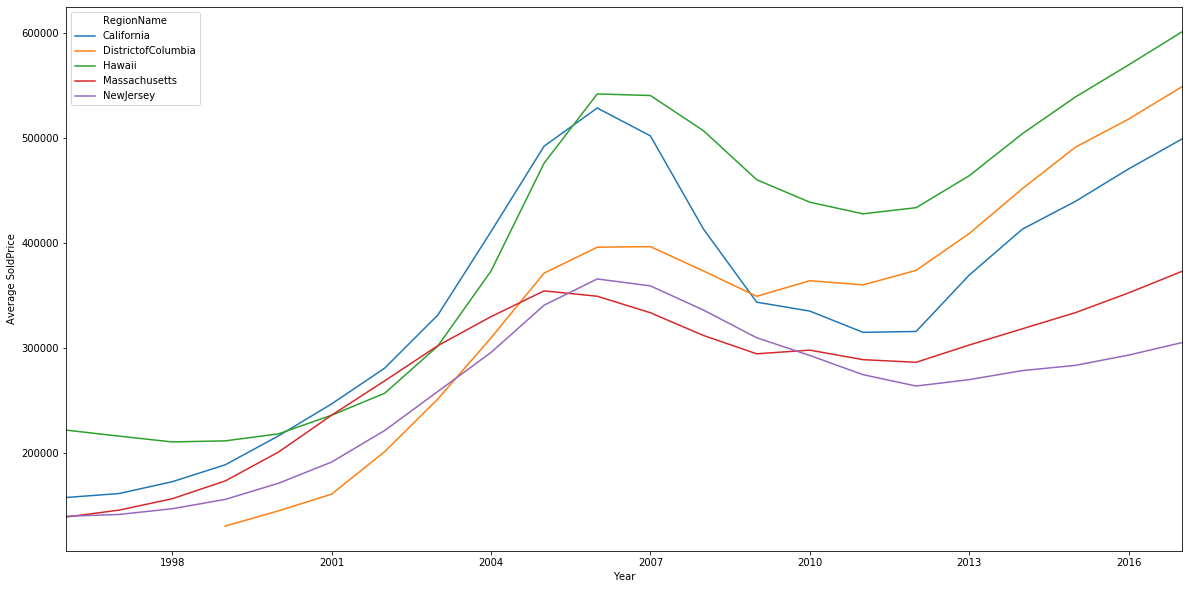

In [10]:
fte_graph = costliest_mean_prices_pivot.plot(figsize=(20,10))
plt.pyplot.gca().xaxis.set_major_locator(plt.ticker.MaxNLocator(integer=True))
plt.pyplot.ylabel('Average SoldPrice')
plt.pyplot.xlabel('Year')


In [11]:
cheapest_mean_prices_pivot = cheapest_mean_sale_price.pivot(index='year', columns='RegionName', values='MedianSoldPrice_AllHomes')

cheapest_mean_prices_pivot


RegionName,Arkansas,Iowa,Ohio,Oklahoma,WestVirginia
year,,,,,
1996,64355.555556,NaN,88911.111111,56677.777778,NaN
1997,66833.333333,NaN,92025.000000,58683.333333,NaN
1998,69150.000000,NaN,95825.000000,61750.000000,NaN
1999,70075.000000,NaN,100300.000000,64558.333333,NaN
2000,72400.000000,NaN,105600.000000,67500.000000,NaN
2001,75600.000000,NaN,110066.666667,70425.000000,NaN
2002,77400.000000,NaN,113625.000000,72341.666667,NaN
2003,82000.000000,NaN,118000.000000,74975.000000,NaN
2004,87508.333333,NaN,122191.666667,77800.000000,NaN


Text(0.5, 0, 'Year')

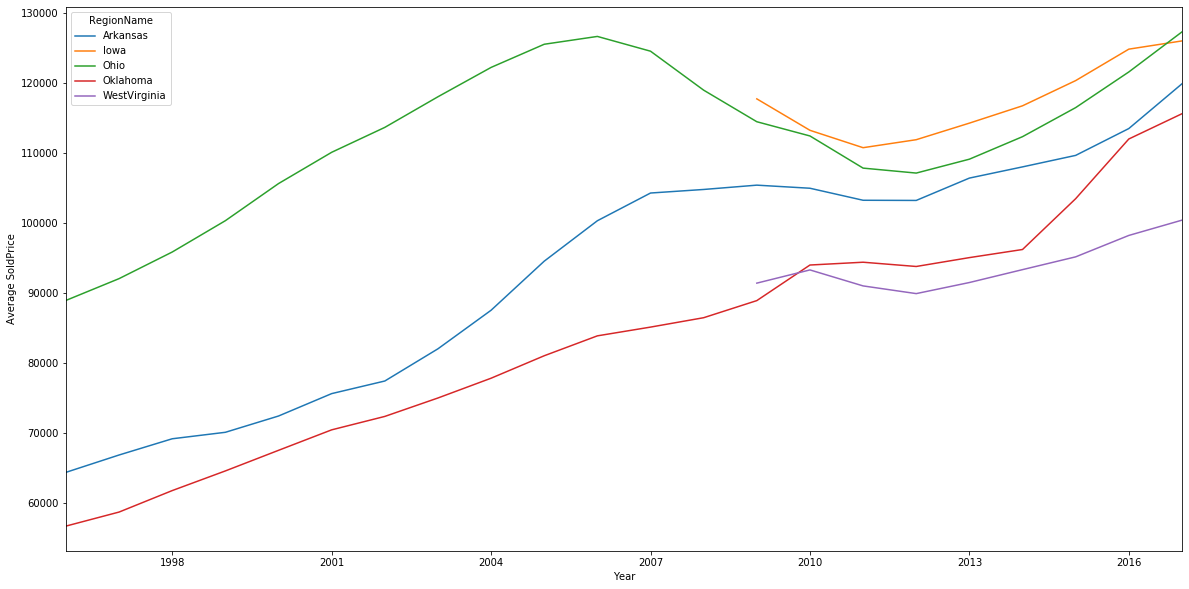

In [12]:
fte_graph = cheapest_mean_prices_pivot.plot(figsize=(20,10))
plt.pyplot.gca().xaxis.set_major_locator(plt.ticker.MaxNLocator(integer=True))
plt.pyplot.ylabel('Average SoldPrice')
plt.pyplot.xlabel('Year')


In [13]:
#Let's prepare a dataframe to predict Cal prices using fb Prophet.
cal_df = state_time_series[state_time_series.RegionName.str.contains('California')]
cal_df_median_prices = cal_df[['Date','RegionName', 'MedianSoldPrice_AllHomes']].dropna()
cal_df_for_prophet = cal_df_median_prices[['Date','MedianSoldPrice_AllHomes']]
cal_df_for_prophet

,Date,MedianSoldPrice_AllHomes
3,1996-04-30,155725.0
48,1996-05-31,157525.0
94,1996-06-30,159025.0
140,1996-07-31,159775.0
186,1996-08-31,160000.0
...,...,...
12043,2016-02-29,409000.0
12095,2016-03-31,416750.0
12147,2016-04-30,427700.0
12199,2016-05-31,433800.0


In [14]:
#Rename our columns per prophet's requirements
cal_df_for_prophet = cal_df_for_prophet.rename(columns={"Date":"ds", "MedianSoldPrice_AllHomes":"y"})
cal_df_for_prophet

,ds,y
3,1996-04-30,155725.0
48,1996-05-31,157525.0
94,1996-06-30,159025.0
140,1996-07-31,159775.0
186,1996-08-31,160000.0
...,...,...
12043,2016-02-29,409000.0
12095,2016-03-31,416750.0
12147,2016-04-30,427700.0
12199,2016-05-31,433800.0


In [15]:
m = Prophet()
m.fit(cal_df_for_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [16]:
future = m.make_future_dataframe(periods=50, freq='M')
future.tail()

,ds
288,2020-04-30
289,2020-05-31
290,2020-06-30
291,2020-07-31
292,2020-08-31


In [17]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
288,2020-04-30,565285.677004,481300.469395,662090.502031,479041.822831,656905.292218,2105.938133,2105.938133,2105.938133,2105.938133,2105.938133,2105.938133,0.0,0.0,0.0,567391.615136
289,2020-05-31,567975.155603,483496.826909,671790.450017,477907.246528,662565.743048,6862.900555,6862.900555,6862.900555,6862.900555,6862.900555,6862.900555,0.0,0.0,0.0,574838.056158
290,2020-06-30,570577.876828,486051.444589,678583.952983,477724.166146,667913.462197,8680.566423,8680.566423,8680.566423,8680.566423,8680.566423,8680.566423,0.0,0.0,0.0,579258.443251
291,2020-07-31,573267.355427,486927.969397,685697.450650,478630.038879,674209.647219,10519.408362,10519.408362,10519.408362,10519.408362,10519.408362,10519.408362,0.0,0.0,0.0,583786.763790
292,2020-08-31,575956.834027,484867.838022,687631.993337,479357.630829,679798.231088,7190.774948,7190.774948,7190.774948,7190.774948,7190.774948,7190.774948,0.0,0.0,0.0,583147.608975


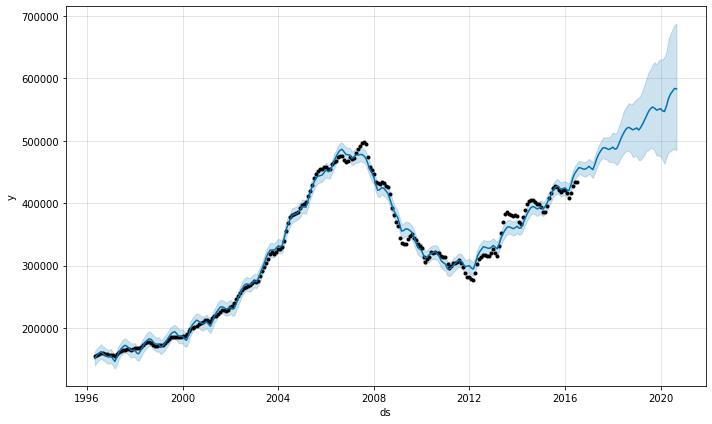

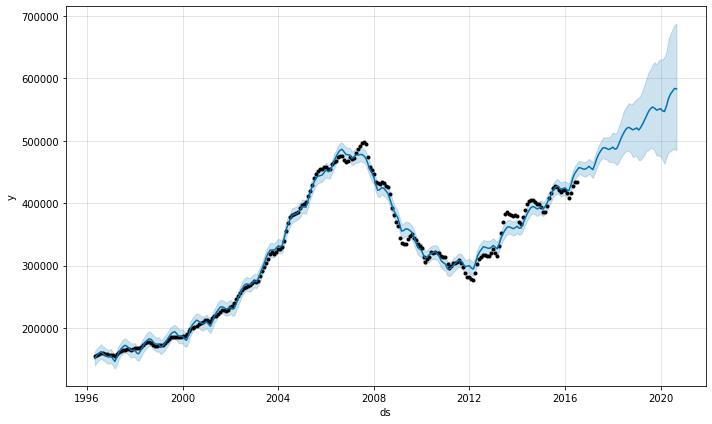

In [18]:
m.plot(forecast)

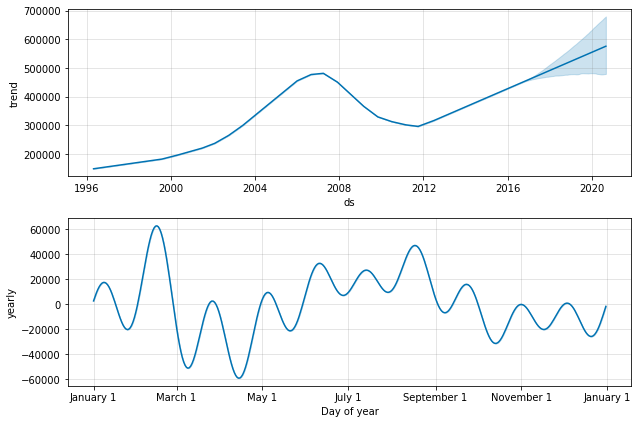

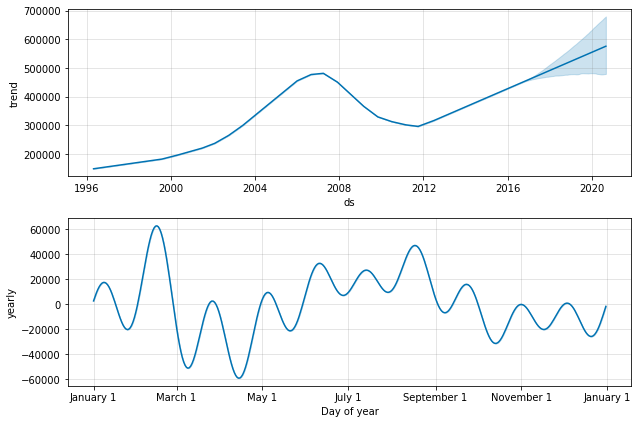

In [19]:
m.plot_components(forecast)